In [16]:
import seaborn as sns
from typing import Union
from sklearn.decomposition import non_negative_factorization
import numpy as np
import scanpy as sc
from pathlib import Path
from tqdm import tqdm
import functools
import pickle

In [4]:

def cosine_similarity_rows(A, B):
    norms_A = np.linalg.norm(A, axis=1)
    norms_B = np.linalg.norm(B, axis=1)
    dot_products = np.einsum('ij,ij->i', A, B)
    return dot_products / (norms_A * norms_B)

def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

In [5]:
create_folders(
    str(Path.cwd()),
    {
        "data": {
            "inputQuery": {},
            "inputRef": {},
            "nico_out": {},
        }
    }
)

In [6]:
adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
sc.pp.filter_genes(adata_sp, min_counts=3)
#sc.pp.log1p(adata_sp)
#sc.pp.normalize_total(adata_sp, target_sum=1e6)

sc.pp.filter_genes(adata_sc, min_counts=3)
#sc.pp.log1p(adata_sc)
#sc.pp.normalize_total(adata_sc, target_sum=1e6)

In [7]:
shared_genes_mask = np.isin(adata_sc.var_names, adata_sp.var_names)
#shared_genes = list(set.intersection(set(adata_sc.var_names), set(adata_sp.var_names)))
shared_genes = list(adata_sc[:, shared_genes_mask].var_names)
X_sp = adata_sp[:, shared_genes].X.toarray().copy()
X_sc = adata_sc.X.toarray().copy()

100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


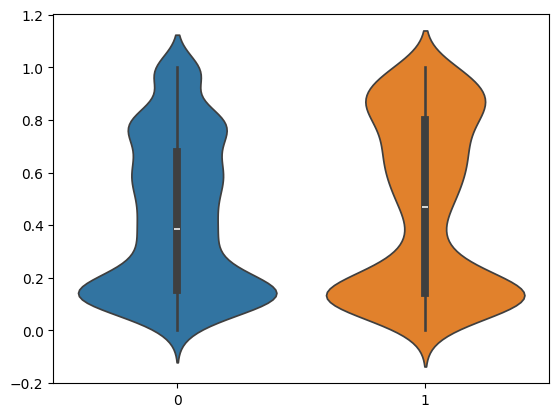

In [17]:
n_components_range = [2 ** x for x in range(2, 4)]
test = {n_components: (non_negative_factorization(X_sc, n_components=n_components)) for n_components in tqdm(n_components_range)}
sns.violinplot([cosine_similarity_rows(X_sc[:, shared_genes_mask], nmf_res[0] @ nmf_res[1][:, shared_genes_mask]) for nmf_res in test.values()])

with open("nmf_test_results.pkl", "wb") as f:
    pickle.dump(test, f)

  0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 14.68it/s]


<Axes: >

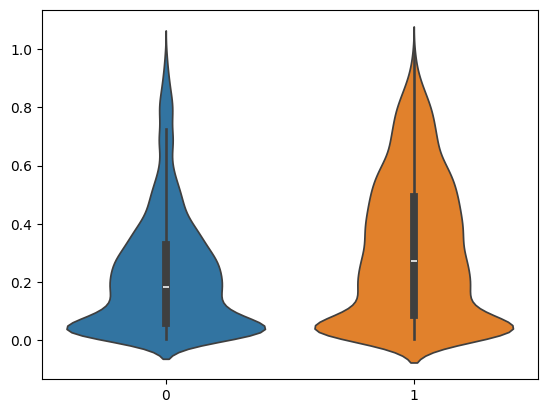

In [12]:
test2 = {n_components: non_negative_factorization(X_sp, H=nmf_res[1][:, shared_genes_mask], update_H=False, init="custom") for n_components, nmf_res in tqdm(test.items())}
sns.violinplot([cosine_similarity_rows(X_sp, x[0] @ x[1]) for x in test2.values()])

with open("nmf_test2_results.pkl", "wb") as f:
    pickle.dump(test2, f)

  0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskr

<Axes: >

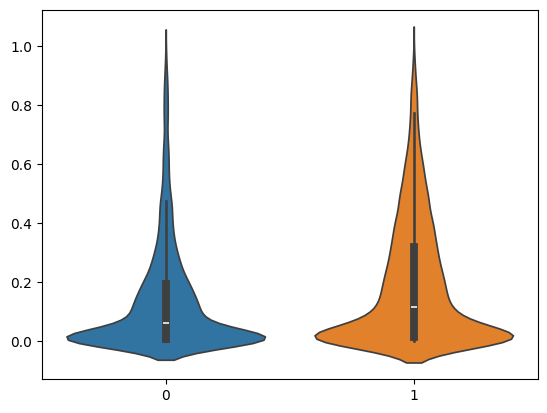

In [13]:
test3 = {n_components: functools.reduce(lambda a, b: np.hstack([a, b]), [(lambda x: x[0] @ nmf_res[1][:, shared_genes_mask])(non_negative_factorization(X_sp[:, ~np.isin(shared_genes, gene)], H=nmf_res[1][:, shared_genes_mask][:, ~np.isin(shared_genes, gene)], update_H=False, init="custom"))[:, np.isin(shared_genes, gene)] for gene in shared_genes]) for n_components, nmf_res in tqdm(test.items())}
sns.violinplot([cosine_similarity_rows(X_sp, x_r) for x_r in test3.values()])

with open("nmf_test3_results.pkl", "wb") as f:
    pickle.dump(test3, f)